## Imports

In [38]:
import xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

## Load & Clean Data

- We should drop `generation hydro pumped storage aggregated` (all null)
- We should drop `forecast wind offshore eday ahead`

In [23]:
og_data = pd.read_csv("../Josh/EnergyAndAvgWeather.csv")

In [24]:
og_data

,Unnamed: 0,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
0,0,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.100,65.410,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.00,0.0,0.0,0.0,800.0
1,1,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.100,64.920,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.00,0.0,0.0,0.0,800.0
2,2,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.330,64.480,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.00,0.0,0.0,0.0,800.0
3,3,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.270,59.320,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.00,0.0,0.0,0.0,800.0
4,4,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.410,56.040,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.00,0.0,0.0,0.0,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35140,320.0,212.4,0.0,5863.8,3758.6,244.6,0.0,0.0,0.0,NaN,253.4,1115.8,1921.8,0.0,5674.2,57.8,92.0,36.4,279.8,0.0,6389.6,27.0,NaN,6490.6,25875.6,25847.4,55.716,60.274,282.122000,280.750000,283.750000,1020.0,75.4,3.2,182.0,0.18,0.0,0.0,16.6,744.2
35060,35141,320.0,215.0,0.0,5711.6,3656.2,240.0,0.0,0.0,0.0,NaN,585.6,1134.6,1779.6,0.0,5674.4,57.4,92.8,27.6,282.4,0.0,6574.8,18.6,NaN,6610.0,25763.4,25687.4,56.028,60.280,281.582000,279.950000,283.550000,1020.0,72.6,3.4,204.4,0.06,0.0,0.0,20.6,740.2
35061,35142,319.8,207.6,0.0,5943.8,3684.6,238.6,0.0,0.0,0.0,NaN,645.2,1156.0,1776.8,0.0,5674.8,57.2,91.6,26.8,283.2,0.0,6617.0,17.2,NaN,6688.2,26137.4,26138.0,56.376,60.642,281.006000,279.550000,282.750000,1020.0,80.8,3.4,175.8,0.06,0.0,0.0,17.4,740.2
35062,35143,324.4,225.2,0.0,5971.8,3745.4,233.8,0.0,0.0,0.0,NaN,646.4,1160.6,1898.0,0.0,5674.0,58.0,91.8,39.6,280.2,0.0,6562.4,37.4,NaN,6698.6,26411.8,26461.6,56.940,61.106,280.274000,278.750000,281.950000,1020.0,78.8,3.4,287.6,0.06,0.0,0.0,10.4,740.2


In [59]:
data = pd.read_csv("../Josh/EnergyAndAvgWeather.csv")
data.shape

(35064, 41)

In [60]:
data = data.drop(columns=['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead', 'Unnamed: 0'])

In [61]:
data = data.dropna(how='all')
data = data.dropna(thresh=20)

In [62]:
data = data.fillna(data.mean())

In [63]:
data.isnull().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil coal-derived gas             0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation fossil oil shale                    0
generation fossil peat                         0
generation geothermal                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation marine                              0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind offshore                       0
generation wind onshore                        0
forecast solar day a

## Quick Data Vis Before Model Creation

### Corr Mat

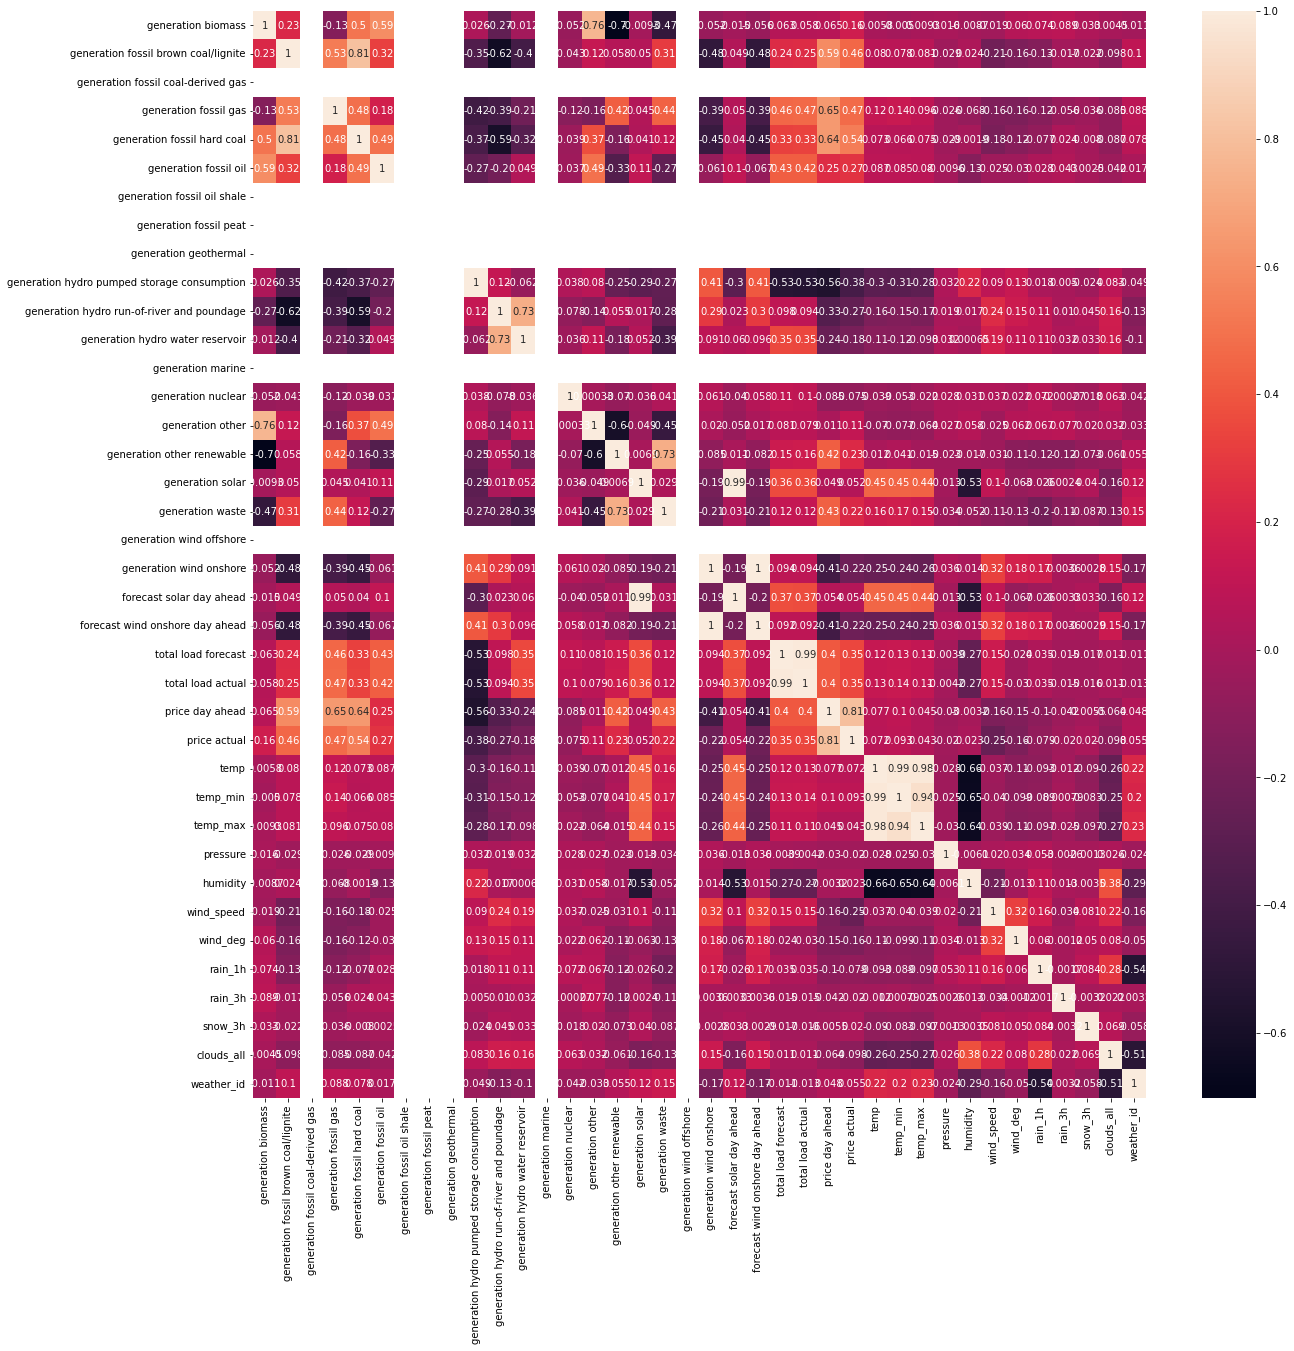

In [44]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), annot=True, fmt='.2g')
plt.show()

### PCA

In [231]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [127]:
df_use_pca = data[['generation fossil gas', 'price actual', 'generation fossil brown coal/lignite', 'temp']]
df_use_pca = StandardScaler().fit_transform(df_use_pca)

In [131]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(df_use_pca)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3', 'pc4'])

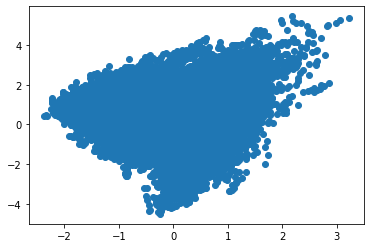

In [136]:
# The pca looks a bit like a blob... no distinct groups are emerging
plt.scatter(principalDf['pc4'], principalDf['pc1'])

## Data Preprocessing
- Predict Price Actual

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [69]:
data = data[['forecast solar day ahead',
       'forecast wind onshore day ahead',
       'price day ahead', 'price actual', 'temp',
       'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'generation fossil gas']]

In [83]:
# Move target to the end, for simplicity
data['target'] = data['generation fossil gas'].copy()
data = data.drop(columns=['generation fossil gas']) # we shouldn't use price day ahead
data = data.rename(columns={'target' : 'generation fossil gas'})

# split into training and testing
training, testing = train_test_split(data, test_size=0.2)
#price_day_ahead_test = testing['price day ahead']
# We should not be training on this piece of info
training, testing = training.drop(columns=['price day ahead', 'price actual']), testing.drop(columns=['price day ahead', 'price actual'])

# minmax scaling
training = pd.DataFrame(MinMaxScaler().fit_transform(training), columns=training.columns)
testing = pd.DataFrame(MinMaxScaler().fit_transform(testing), columns=testing.columns)

X_train, y_train = training.drop(columns=['generation fossil gas']), training['generation fossil gas']
X_test, y_test = testing.drop(columns=['generation fossil gas']), testing['generation fossil gas']
#X_train, y_train = training[:, :-1], training[:, -1]
#X_test, y_test = testing[:, :-1], testing[:, -1]

### XGBOOST

In [84]:
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_validate
from numpy import absolute
from sklearn.metrics import mean_squared_error

In [85]:
model = XGBRegressor(random_state=42)
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [86]:
scores

array([-0.06918879, -0.06675656, -0.06808871, -0.06867244, -0.06729189,
       -0.06791866, -0.06774389, -0.06775985, -0.06904434, -0.06753201])

In [87]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.068 (0.001)


In [88]:
model.fit(X_train, y_train)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [89]:
X_pred_test = model.predict(X_test)

In [90]:
mean_squared_error(y_test, X_pred_test)

0.023118137228749894

In [80]:
price_day_ahead_test = price_day_ahead_test.to_numpy()
price_day_ahead_test = MinMaxScaler().fit_transform(price_day_ahead_test.reshape(-1,1))
mean_squared_error(y_test, price_day_ahead_test)

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

### Model Interpretability Portion

In [81]:
import shap

In [91]:
exp = shap.TreeExplainer(model, feature_dependence='independent', data=X_train)

feature_dependence = "independent" has been renamed to feature_perturbation = "interventional"! See GitHub issue #882.


In [93]:
X_train

,forecast solar day ahead,forecast wind onshore day ahead,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
0,0.395594,0.314814,0.669352,0.001030,0.552408,0.034965,0.585424,0.000000,0.0,0.0,0.206522,0.992244
1,0.115421,0.332367,0.230860,0.001021,0.628895,0.069930,0.605735,0.196078,0.0,0.0,0.343478,0.826593
2,0.457242,0.296068,0.776110,0.001006,0.339943,0.027972,0.262843,0.000000,0.0,0.0,0.130435,0.991690
3,0.186990,0.183891,0.546308,0.001021,0.558074,0.097902,0.244922,0.000000,0.0,0.0,0.206522,0.992244
4,0.392888,0.239115,0.790773,0.000996,0.515581,0.104895,0.591398,0.000000,0.0,0.0,0.086957,0.991136
...,...,...,...,...,...,...,...,...,...,...,...,...
25839,0.226470,0.242468,0.308740,0.001064,0.657224,0.034965,0.612903,0.000000,0.0,0.0,0.000000,0.990028
25840,0.367875,0.221455,0.530833,0.001020,0.691218,0.048951,0.568698,0.000000,0.0,0.0,0.250000,0.992798
25841,0.024770,0.412708,0.623160,0.001007,0.597734,0.090909,0.752091,0.000000,0.0,0.0,0.000000,0.990028
25842,0.239722,0.478038,0.396200,0.001058,0.410765,0.048951,0.126643,0.000000,0.0,0.0,0.043478,0.990582


In [95]:
shap_values = exp.shap_values(X_train.iloc[0])
shap.initjs()
display(shap.force_plot(exp.expected_value, shap_values, X_train.iloc[0]))

/Users/jacquelinemitchell/opt/anaconda3/envs/ECS171/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/jacquelinemitchell/opt/anaconda3/envs/ECS171/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/jacquelinemitchell/opt/anaconda3/envs/ECS171/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/jacquelinemitchell/opt/anaconda3/envs/ECS171/lib/python3.8/site-packages/xgb